In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Import the necessary libraries

In [37]:
import os
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sn
import cv2

import glob

# Define the paths for training, testing and validation directories

In [4]:
train_dir = '../input/chest-xray-pneumonia/chest_xray/train'
test_dir = '../input/chest-xray-pneumonia/chest_xray/test'
val_dir = '../input/chest-xray-pneumonia/chest_xray/val'


In [5]:
pneumonia_train_images = glob.glob(train_dir+"/PNEUMONIA/*.jpeg")
normal_train_images = glob.glob(train_dir+"/NORMAL/*.jpeg")

# Visualize the data

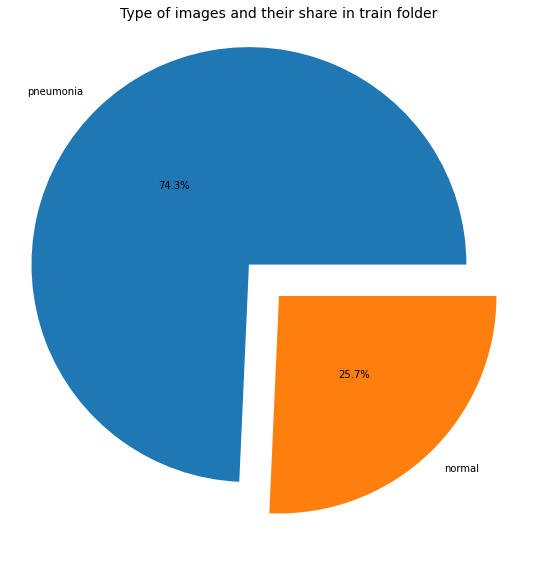

In [53]:
plt.figure(figsize=(15, 10))
plt.pie(x=np.array([len(pneumonia_train_images), len(normal_train_images)]), autopct="%.1f%%", explode=[0.2,0], labels=["pneumonia", "normal"], pctdistance=0.5)
plt.title("Type of images and their share in train folder", fontsize=14);

**We see that we have an imbalanced dataset. Hence, we will be using image augmentation techniques to compensate for this.**

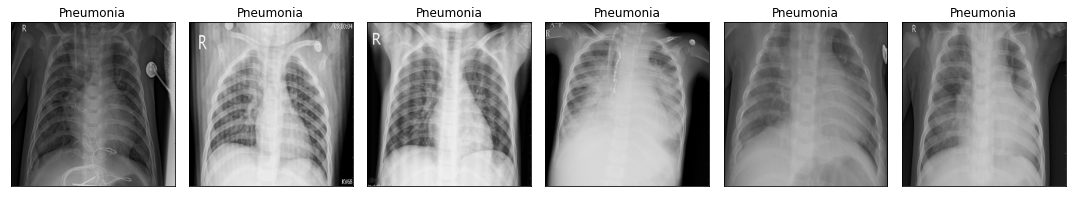

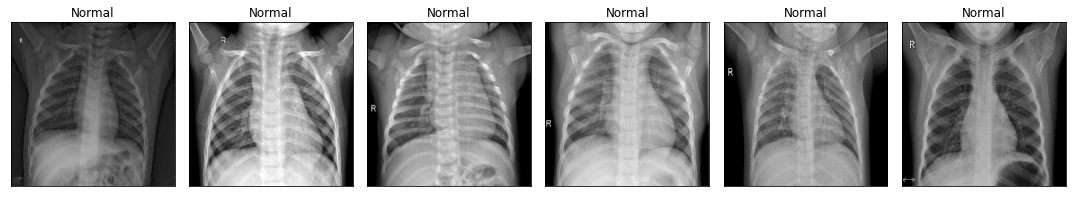

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(pneumonia_train_images[i])
    img = cv2.resize(img, (512,512))
    ax.imshow(img)
    ax.set_title("Pneumonia")
    
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(normal_train_images[i])
    img = cv2.resize(img, (220,220))
    ax.imshow(img)
    ax.set_title("Normal")
fig.tight_layout()    
plt.show()

# Canny edge detection

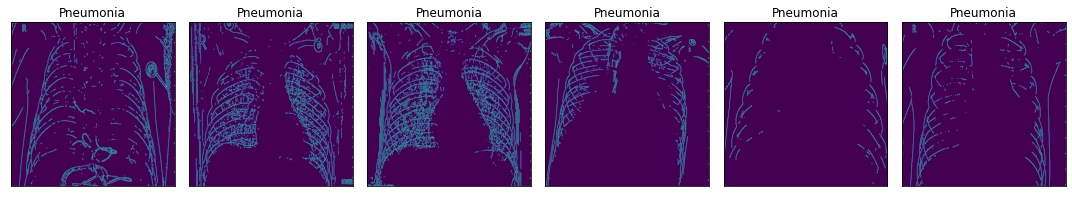

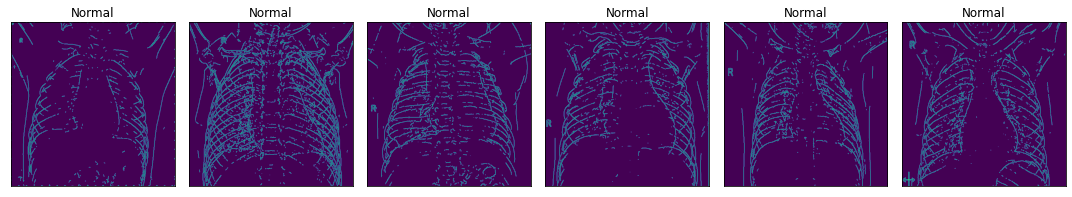

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(pneumonia_train_images[i])
    img = cv2.resize(img, (512,512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.Canny(img, 80, 100)
    ax.imshow(img)
    ax.set_title("Pneumonia")
fig.tight_layout()
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(normal_train_images[i])
    img = cv2.resize(img, (512,512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.Canny(img, 80, 100)
    ax.imshow(img)
    ax.set_title("Normal")
fig.tight_layout()    
plt.show()

**We can see that it is difficult to detect edges in the x-rays with pneumonia whereas the normal images are clear with prominent edges**

# Create imgae data generators
- We have rescaled the images by dividing the pixel values by 255
- To maintain uniform size of the image, we have also configured the images to shape (220, 220)

In [5]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   zoom_range = 0.2)
val_datagen = ImageDataGenerator(rescale = 1./255.,)
test_datagen = ImageDataGenerator(rescale = 1./255.,)


train_generator = train_datagen.flow_from_directory(train_dir, batch_size=20, class_mode='binary', target_size = (220, 220))
validation_generator = val_datagen.flow_from_directory(test_dir, batch_size=20, class_mode = 'binary', target_size=(220, 220))
test_generator = test_datagen.flow_from_directory(val_dir,shuffle=False, batch_size=20, class_mode = 'binary', target_size=(220, 220))

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Define the input shape of the images to be fed into the neural network

In [46]:
input_shape = (220, 220, 3)

# Model creation
## Transfer Learning

- ResNet50 model is used here as base model for transfer learning
- We have made the layers of the base model non-trainable
    - This would fix the weights of the layers of the base model
    - Only the additional layers that we will add on top of the base layer will be trained

In [7]:
# define the model
base_model = tf.keras.applications.ResNet50V2(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model.layers:
    layer.trainable = False
    
    
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()
        

94674944/94668760 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 23,827,201
Trainable params: 262,401
Non-trainable params: 23,564,800
_________________________________________________________________


## Train the model

In [8]:
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=["accuracy"])

callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history = model.fit(train_generator, validation_data=validation_generator, steps_per_epoch = 100, epochs=20, callbacks=callback)

Epoch 1/20
100/100 [==============================] - 209s 2s/step - loss: 0.2663 - accuracy: 0.8802 - val_loss: 0.4107 - val_accuracy: 0.8381
Epoch 2/20
100/100 [==============================] - 200s 2s/step - loss: 0.2004 - accuracy: 0.9156 - val_loss: 0.3291 - val_accuracy: 0.8606
Epoch 3/20
100/100 [==============================] - 206s 2s/step - loss: 0.1353 - accuracy: 0.9416 - val_loss: 0.3705 - val_accuracy: 0.8590
Epoch 4/20
100/100 [==============================] - 201s 2s/step - loss: 0.1245 - accuracy: 0.9480 - val_loss: 0.2306 - val_accuracy: 0.9135
Epoch 5/20
100/100 [==============================] - 202s 2s/step - loss: 0.1290 - accuracy: 0.9494 - val_loss: 0.2978 - val_accuracy: 0.8734
Epoch 6/20
100/100 [==============================] - 208s 2s/step - loss: 0.1497 - accuracy: 0.9297 - val_loss: 0.2400 - val_accuracy: 0.9151
Epoch 7/20
100/100 [==============================] - 201s 2s/step - loss: 0.1324 - accuracy: 0.9439 - val_loss: 0.3093 - val_accuracy: 0.8782

## Save the model

In [ ]:
model.save("model1")

# Model metrics

In [9]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

## Visualize training and validation accuracy and loss


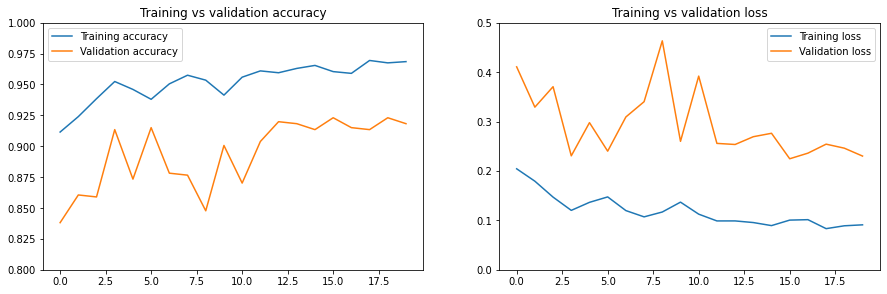

In [62]:
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.ylim(0.8, 1)
plt.legend()
plt.title("Training vs validation accuracy")


plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.ylim(0, 0.5)
plt.legend()
plt.title("Training vs validation loss")

plt.show()

# Predictions

In [47]:
pred = model.predict(test_generator)

In [49]:
pred

array([[0.13311419],
       [0.03757426],
       [0.45833865],
       [0.6005602 ],
       [0.15127373],
       [0.32926476],
       [0.00816309],
       [0.00978136],
       [0.99999964],
       [0.99926865],
       [0.7703501 ],
       [0.8711871 ],
       [0.9447745 ],
       [0.9997182 ],
       [0.99909496],
       [0.9969097 ]], dtype=float32)

**Since the predictions are in form of probabilities, we convert the probabilities with less than 0.5 to 0 and probabilities more than equal to 0.5 to 1. This would help us in calculation of metrics of the model.**

In [63]:
y_pred = []
for prob in pred:
    if prob >= 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

In [64]:
y_pred

[0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]

In [65]:
y_true = test_generator.classes

In [66]:
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

# Confusion matrix

In [70]:
cm = confusion_matrix(y_true, y_pred)

<AxesSubplot:>

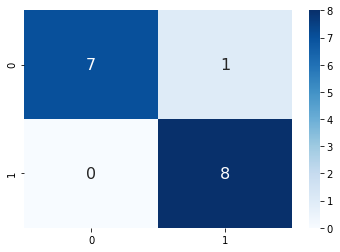

In [74]:
sn.heatmap(cm, annot=True,cmap="Blues", annot_kws={"size": 16})

**We can see that our model misclassified only one image. The image was supposed to be non-pneumonia(0) but our model predicted it to be pneumonic(1)**

# Classification report

In [78]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.89      1.00      0.94         8

    accuracy                           0.94        16
   macro avg       0.94      0.94      0.94        16
weighted avg       0.94      0.94      0.94        16



- Precision is 1 for class 0
    - This means that for all the images that were predicted to belong to class 0 were predicted correctly
- Precision 0.89 for class 1
    - This means that of all the images that the model predicted to belong to class 1, 11% were misclassified as 1, that is False Positive


# Our model achieved an accuracy of 94% which is pretty good

### If you have any suggestions please feel free to comment and if you found this notebook helpful please feel free to upvote